## CodeLab_07: Histogram of Gradients (HoG)

### The development process of the HoG function
-----------------------------------------------------------------------------------
Author: Rajesh Siraskar
Created: 01-Jan-2019

- The author/student undertook development of the custom HoG function as the last step
- Data set creation, model creation using OpenCV HoG function, building a testing notebook etc. were attempted first, before attempting the development of the HoG function
- This notebook shows how the understanding un-folded
- To the student, being average at understanding algorithms and programming, found the process to be enriching and satisfying once the HoG function was developed satisfactorily and hence has kept this 'Code Lab' notebook for observation by the evaluators   
- The **most interesting** moment was the accidental plot of the histograms of magnitudes - which appeared magically to reflect the original image!! Please see cell [8]

- The second most statisfying moment was the ability to understand from the original paper (Dalal N., 2006: Appendix D), the binning logic to create the histogram.

- This HoG function development started on 01-Jan and attained a satisfactory shape on 06-Jan

**Algorithm:**
1. Preprocessing. Apply intensity normalization (e.g. conditional scaling) and a smoothing filter on the given image window I.

2. Calculate an edge map. Estimate directional derivatives in the x and y directions, and derive the gradient magnitudes and gradient angles for each pixel, generating a magnitude map Im (see Fig. 10.7, right) and an angle map Ia.

3. Spatial binning. Perform the following two steps:
    - Group pixels in non-overlapping cells (e.g. 8×8 pixels)
    - Use maps Im and Ia to accumulate magnitude values into direction bins (e.g., nine bins for intervals of 20◦ each, for covering a full 180◦ range) to obtain a voting vector (e.g. of length 9) for each cell; Integral images can be used for a time-efficient calculation of these sums

4. Normalize voting values for generating a descriptor. Perform two steps:
    - Group cells (e.g., 2×2 cells) into one block.
    - Normalize voting vectors over each block and combine them into one block vector (e.g. four cell vectors into a block vector of length 36).

5. Augment all block vectors consecutively; this produces the final HoG descriptor.


In [1]:
# Jupyter specific command to plot images inline with document
%matplotlib inline

# Import modules
import cv2
from matplotlib import pyplot as plt # for displaying images and plots
import numpy as np
from math import floor, pi

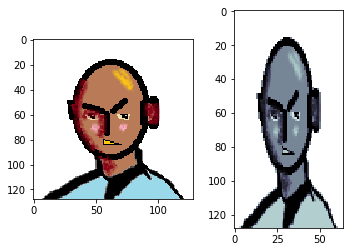

In [2]:
# Read image
img_bgr  = cv2.imread('images/Lab/HoG_lab_1.png')
img_rgb  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Resize needs cols x rows
image = cv2.resize(img_gray, (64, 128))
fig, axes = plt.subplots(1, 2, figsize=(6, 4), gridspec_kw=dict(hspace=0.1, wspace=0.1))
axes[0].imshow(img_rgb, cmap='bone')
axes[1].imshow(image, cmap='bone')

In [3]:
cell_size = (8, 8)
block_cells = 2
step_cells = 1
num_bins = 9
    
# Size of bounding box     
image_size = (image.shape[0], image.shape[1])

# Resize needs cols x rows
image = cv2.resize(image, (64, 128))

# Block size nxn cells. n = block_cells
block_size =  (block_cells*cell_size[0], block_cells*cell_size[1])

# Block stride - can move say one cell at a time, scanning left to right and top to bottom
block_stride = step_cells*cell_size[0]

print('\n HoG Parameters')
print(' ----------------------------')
print('   image_size:', image_size)
print('   cell_size:', cell_size)
print('   block_size:', block_size)
print('   block_stride:', block_stride)
print('   num_bins:', num_bins)
print(' ----------------------------')

image = np.float32(image)/255.0

grad_x = abs(cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1))
grad_y = abs(cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1))

Im, Ia = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)


 HoG Parameters
 ----------------------------
   image_size: (128, 64)
   cell_size: (8, 8)
   block_size: (16, 16)
   block_stride: 8
   num_bins: 9
 ----------------------------


### HoG Vector using simple binning

        Bins: [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100), (100, 120), (120, 140), (140, 160), (160, 180)]        
        
        Find bin h(x1) based on bin limits such that:
        x1 <= x < x2, where x1 and x2 are bin limits
         
        h(x1) <- h(x1) + x
        
        Example:
        If Ia = 32.00, then the bin is (20, 40). Simply add 32.00 to the existing histogram values

In [4]:
angle_slices = int(180.0/num_bins)

# Create angle_slices bins (e.g. 20 deg., if num_bins=9)
Ia_bins = []
for a in range(0, 180, angle_slices):    
    Ia_bins.append((a, a+angle_slices))

print('Binning logic: x1 <= x < x2')
print(Ia_bins)

Binning logic: x1 <= x < x2
[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100), (100, 120), (120, 140), (140, 160), (160, 180)]


In [5]:
# Step.3: Spatial binning
# Group pixels in non-overlapping cells (e.g. 8×8 pixels)
# Use maps Im and Ia to accumulate magnitude values into direction bins 
#  (e.g., nine bins for intervals of 20◦ each, for covering a full 180◦ range) 
#  to obtain a voting vector (e.g. of length 9) for each cell

# 1 histogram per cell with 9 bins
# Create a collection of bins of num_bins length
rows = int(image.shape[0]/cell_size[0])
cols = int(image.shape[1]/cell_size[1])

# Im_bins = [[[0 for n in range(num_bins)] for c in range(cols)] for r in range(rows)]
Im_bins = np.zeros((rows, cols, num_bins))

## Binning Logic 1: Simple binning based on boundaries of bins

i.e. If x1 <= x < x2, then place x in bin with [x1, x2)

In [6]:
print('Binning logic: x1 <= x < x2')
    
## Traverse the image starting at top, then left to right, then next row...

# Keep track of cells
n_cell = 0
n_row = 0
n_col = 0

# Move T-B
n_row = 0
for y in range(0, image.shape[0], cell_size[0]):
    # Move L-R
    n_col = 0
    for x in range(0, image.shape[1], cell_size[1]):
        # Access a pixel in the cell
        for px_row in range(y, y+cell_size[1]):
            for px_col in range(x, x+cell_size[0]):
                # Place the pixel magnitude Im in the appropriate bin
                for n_bin in range(num_bins):
                    # Binning logic: x1 <= x < x2
                    if (Ia[px_row, px_col] >= Ia_bins[n_bin][0] and 
                        Ia[px_row, px_col] <  Ia_bins[n_bin][1]):
                        Im_bins[n_row][n_col][n_bin] += Im[px_row,px_col]

                # Placed in one of the 9 (num_bins) bins
            # end for cell location along columns
        # end for cell location along rows
        # Complete cell covered, move to next cell 
        n_col += 1
    # 1 row of cells L-R covered, proceed to next row
    n_row+=1
# All rows covered L-R, complete image processed  

Binning logic: x1 <= x < x2



 ----- HoG Vector using simple binning ----- 


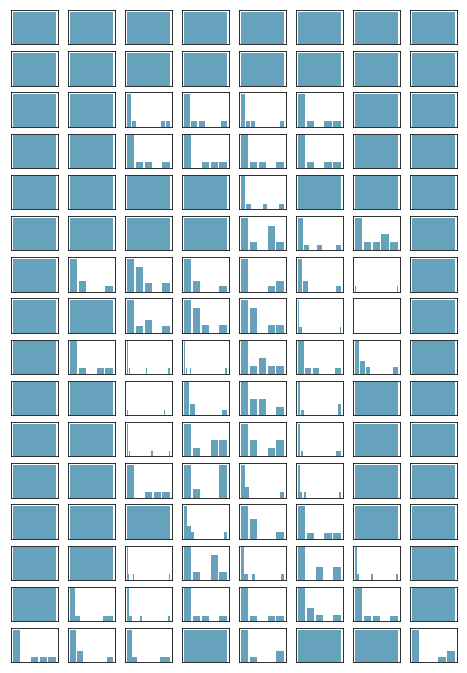

In [7]:
print ('\n ----- HoG Vector using simple binning ----- ')
fig, axes = plt.subplots(Im_bins.shape[0], Im_bins.shape[1], figsize=(8, 12), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.2, wspace=0.2))

for i in range(Im_bins.shape[0]):
    for j in range(Im_bins.shape[1]):
        axes[i][j].hist(x=Im_bins[i][j], bins='auto', color='#006590', alpha = 0.6, rwidth=0.85)

## Binning Logic 2: HoG Vector based on thesis (Dalal N., 2006: Appendix D)

        Here the bins are based on 9 centers:
        Ia_bins:  [0, 20, 40, 60, 80, 100, 120, 140, 160]
        
        Ph.D. Thesis, Navneet DALAL, 2006: 'Finding People in Images and Videos', Appendix 'D'
        
        If x is value to be interpolated into bins and x is such that it lies between x1 and x2,
        where x1 and x2 are centers of two bins and b is the band-width of the bins:
        
        x1 <= x < x2
        
        h(x1) <- h(x1) + w * [1 - (x-x1)/b]
        h(x2) <- h(x2) + w * (x-x1)/b
        
        **Note**: The thesis pg: 131, Appendix D, could there be an error? h(x1) mentioned in the eqn. for h(x2)?
        
        Example:
        If Ia = 32.00, the bin centers are 20 <= x < 40
        h(x1) <- h(x1) + w * [1 - (32-20)/20] = h(x1) + w * 0.9
        h(x2) <- h(x2) + w * [(32-20)/20] = h(x2) + w * 0.1

In [8]:
angle_slices = int(180.0/num_bins)

# Create angle_slices bins (e.g. 20 deg., if num_bins=9)
Ia_bin_centers = []
for a in range(0, 180, angle_slices):    
    Ia_bin_centers.append(a)

print('Binning logic: Dalal N., 2006: Appendix D')
print(Ia_bin_centers)

Binning logic: Dalal N., 2006: Appendix D
[0, 20, 40, 60, 80, 100, 120, 140, 160]


In [9]:
# Create bin centers (e.g. 20 deg., if num_bins=9)
[angle for angle in range(0, 180, angle_slices)]

[0, 20, 40, 60, 80, 100, 120, 140, 160]

In [10]:
# Step.3: Spatial binning
# Group pixels in non-overlapping cells (e.g. 8×8 pixels)
# Use maps Im and Ia to accumulate magnitude values into direction bins 
#  (e.g., nine bins for intervals of 20◦ each, for covering a full 180◦ range) 
#  to obtain a voting vector (e.g. of length 9) for each cell

# 1 histogram per cell with 9 bins
# Create a collection of bins of num_bins length
rows = int(image.shape[0]/cell_size[0])
cols = int(image.shape[1]/cell_size[1])

#Im_bins = [[[0 for n in range(num_bins)] for c in range(cols)] for r in range(rows)]
Im_bins = np.zeros((rows, cols, num_bins))

In [11]:
print('Binning logic: Dalal N., 2006: Appendix D')

## Traverse the image starting at top, then left to right, then next row...

# Keep track of cells
n_cell = 0
n_row = 0
n_col = 0

# Histogram bin band-width
b = Ia_bin_centers[1] - Ia_bin_centers[0]

# Move T-B
n_row = 0
for y in range(0, image.shape[0], cell_size[0]):
    # Move L-R
    n_col = 0
    for x in range(0, image.shape[1], cell_size[1]):
        # Access a pixel in the cell
        for px_row in range(y, y+cell_size[1]):
            for px_col in range(x, x+cell_size[0]):
                
                ### Binning logic: Dalal N., 2006: Appendix D
                # Place the pixel magnitude Im in the appropriate bin
                # x1 <= x < x2
                # h(x1) <- h(x1) + w * [1 - (x-x1)/b]
                # h(x2) <- h(x1) + w * (x-x1)/b
                # w = Im at that pixel itself
                for n_bin in range(num_bins):
                    if (Ia[px_row, px_col] >= Ia_bin_centers[n_bin] and 
                        Ia[px_row, px_col] <  Ia_bin_centers[n_bin+1]):

                        # Allow if we are at last-but-one bin
                        if (n_bin+1 < num_bins):
                            Im_bins[n_row][n_col][n_bin] += Im[px_row,px_col] * (1 - (Ia[px_row,px_col] - Ia_bin_centers[n_bin])/b)
                            Im_bins[n_row][n_col][n_bin+1] += Im[px_row,px_col] * (Ia[px_row,px_col] - Ia_bin_centers[n_bin])/b
                        else:
                            # Split into last and 1st bins:
                            Im_bins[n_row][n_col][n_bin] += Im[px_row,px_col] * (1 - (Ia[px_row,px_col] - Ia_bin_centers[n_bin])/b)
                            Im_bins[n_row][n_col][0] += Im[px_row,px_col] * (Ia[px_row,px_col] - Ia_bin_centers[n_bin])/b

                # Placed in one of the 9 (num_bins) bins
            # end for cell location along columns
        # end for cell location along rows
        # Complete cell covered, move to next cell 
        n_col += 1
    # 1 row of cells L-R covered, proceed to next row
    n_row+=1
# All rows covered L-R, complete image processed

# Create a feature vector
hog_features = Im_bins.ravel().reshape(-1, 1)

Binning logic: Dalal N., 2006: Appendix D



 ------ HoG Vector based on thesis (Dalal N., 2006: Appendix D ------ 


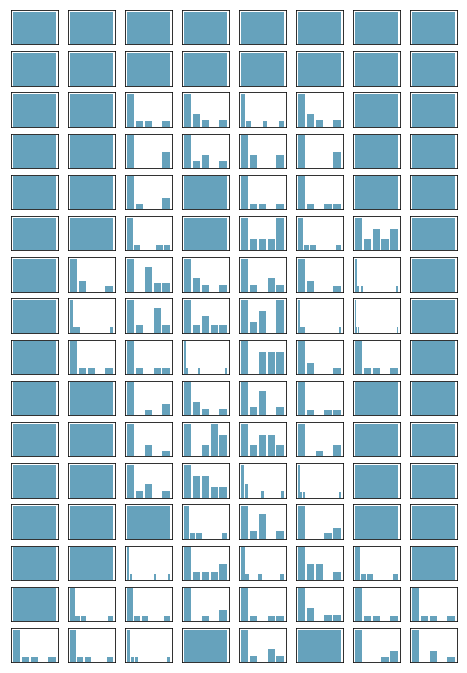

In [25]:
print ('\n ------ HoG Vector based on thesis (Dalal N., 2006: Appendix D ------ ')

fig, axes = plt.subplots(Im_bins.shape[0], Im_bins.shape[1], figsize=(8, 12), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.2, wspace=0.2))

for i in range(Im_bins.shape[0]):
    for j in range(Im_bins.shape[1]):
        axes[i][j].hist(x=Im_bins[i][j], bins='auto', color='#006590', alpha = 0.6, rwidth=0.85)